# Random Forest Tutorial

In [179]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import tree 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# For tokenization
import nltk
# For converting words into frequency counts
from sklearn.feature_extraction.text import CountVectorizer

* Every tree in a random forest uses a different bootstrap sample of the training set.
* To train a tree in a random forest, a first randomly select a subset of features. 
* A reasonable implementation for random forests would be for each tree to "vote".

## Data and preprocessing

I am going to do some sentiment analysis with the [IMDB movie review data set](https://www.kaggle.com/utathya/imdb-review-dataset). The task is to assign positive or negative label to a text based on the sentiment or attitude expressed in it. For speed, I will subset the dataset to 5000 samples.

In [133]:
# Read IMDB movie reviews into a pandas DataFrame
imdb_df = pd.read_csv('data/imdb_master.csv', encoding = "ISO-8859-1")
imdb_df.head()

,Unnamed: 0,type,review,label,file
0,0,test,Once again Mr. Costner has dragged out a movie...,neg,0_2.txt
1,1,test,This is an example of why the majority of acti...,neg,10000_4.txt
2,2,test,"First of all I hate those moronic rappers, who...",neg,10001_1.txt
3,3,test,Not even the Beatles could write songs everyon...,neg,10002_3.txt
4,4,test,Brass pictures (movies is not a fitting word f...,neg,10003_3.txt


In [134]:
from nltk.corpus import stopwords
import string
stop_words_extended = list(set(stopwords.words('english')))
stop_words_extended.extend(['``','`','br','"',"”", "''", "'s", '!', '#','$','%','&', "'", "''", "'d", "'ll", "'m", "'re", "'s", "'the", "'ve", '(', ')', '*', '**', '***', '****', ',', '-', '--', '.', '..', '...', '.the', '/', '0', '1', '1.', '1/10', '1/2', '10', '10.', '10/10', '100', '11', '12', '13', '13th', '14', '15', '16', '17', '18', '1930s', '1939', '1940', '1950', '1950s', '1960', '1960s', '1970', '1970s', '1978', '1980', '1980s', '1983', '1984', '1997', '1999', '1st', '2', '2.', '2/10', '20', '2000', '2001', '2003', '2004', '2005', '2006', '2007', '20th', '24', '25', '2nd', '3', '3.', '3/10', '30', '3rd', '4', '4/10', '40', '45', '5', '50', '6', '60', '60s', '7', '7/10', '70', '70s', '8', '8/10', '80', '80s', '9', '9/10', '90', '90s', ':', ';', '<', '>', '?', '@', '[', ']', '`', '``'])

In [135]:
# Only keep the reviews with pos and neg labels
imdb_df = imdb_df[imdb_df['label'].str.startswith(('pos','neg'))]

# Sample 5000 rows from the dataframe. 
imdb_df_subset = imdb_df.sample(n = 5000)

# Convert a collection of text documents to a matrix of token presence or absence. 
# We are using only 5000 words, English stopwords, and tokenization is done using
# nltk, which is a popular text processing library.
movie_vec = CountVectorizer(max_features=5000, 
                            tokenizer=nltk.word_tokenize, 
                            stop_words=stop_words_extended, #Removed punctuation, some numbers, and special characters
                            binary = True)
# Create X and y
X_imdb = movie_vec.fit_transform(imdb_df_subset['review'])
y_imdb = imdb_df_subset.label

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [180]:
imdb_df_subset.head()

,Unnamed: 0,type,review,label,file,odd_char
24639,24639,test,"When I first saw this show, I was 9, and it ca...",pos,9677_10.txt,False
30822,30822,train,I'm not sure why Spike Lee made this train wre...,neg,3991_4.txt,False
4404,4404,test,Do you get it? Like the car. These are the jok...,neg,2714_2.txt,False
4004,4004,test,"As I post this comment, IMDb currently rates A...",neg,2354_3.txt,False
43136,43136,train,I saw this film in the worst possible circumst...,pos,3823_9.txt,False


## Random Forests

### Steps that need to be taken in Scikit Learn

1. Split `X_imdb` into train (80%) and test (20%). 
2. Train a [random forest classifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) on the train portion.
4. Score the classifier on the test portion and compare the results with the training score.

In [53]:
from sklearn.ensemble import RandomForestClassifier

In [54]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_imdb, 
                                                    y_imdb, 
                                                    test_size = 0.20, 
                                                    random_state = 12)

In [55]:
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [56]:
random_forest.score(X_test, y_test)

0.819

The accuracy of the random forest classifier is very high when using 100 trees.  

**Note:** After adding more symbols and punctuation in the stopwords, the accuracy of the model fell by almost 7%

## What makes a good feature to our trees?

We are setting the number of trees we are interested in, and we may be able to define also the depth per tree. But what are the words that are making the splits? The previous model uses GINI coefficient. GINI is a measure of homogeneity, just as entropy. GINI however, is less computationally expensive. It lets us know how often a randomly chosen object from the set is labled incorrectly. It is measured from 0 to 0.5; 0 being that our data is more homogeneous. 

Let's see for our random forest what features are the ones that help us have best divisions. Can I improve this? 

In [57]:
feature_names = movie_vec.get_feature_names()

In [58]:
random_forest.n_features_

5000

In [59]:
feature_importance = random_forest.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())


In [60]:
feats = {} # a dict to hold feature_name: feature_importance
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair 

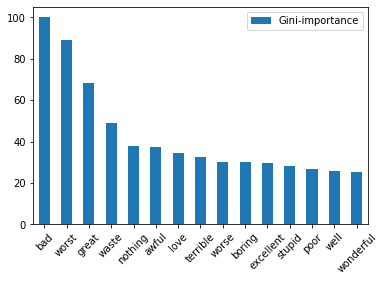

In [61]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:15].plot(kind='bar', rot=45)


With the new stopwords removed, symbols did not figure out in our most important split features.

With the new stop words, we can see words such as `bad` and `worst` gaining importance.

However, I would also want to see which symbols I missed to remove and what importance they have according to their GINI gain. I will explore this later.

### Tuning hyperparameters

1. How many trees should I use? 
2. Run a dictionary to report test and train scores for each value of n_estimators. 
3. Consider if this is under or overfitting.

In [181]:
n_estimators_dict = {'n_estimators':[], 'train_score':[], 'test_score':[]}

# Jumping every 5 trees to speed up process.
for n_est in range(1, 100, 5):
    random_forest = RandomForestClassifier(n_estimators = n_est)
    random_forest.fit(X_train, y_train)
    
    train_score = random_forest.score(X_train, y_train)        
    test_score = random_forest.score(X_test, y_test)    

    n_estimators_dict['n_estimators'].append(n_est)    
    n_estimators_dict['train_score'].append(train_score)
    n_estimators_dict['test_score'].append(test_score)
n_estimators_df = pd.DataFrame(n_estimators_dict)
n_estimators_df        

,n_estimators,train_score,test_score
0,1,0.87575,0.683
1,6,0.96975,0.679
2,11,0.99825,0.742
3,16,0.99700,0.771
4,21,0.99975,0.787
5,26,1.00000,0.771
6,31,1.00000,0.778
7,36,1.00000,0.793
8,41,1.00000,0.802
9,46,1.00000,0.793


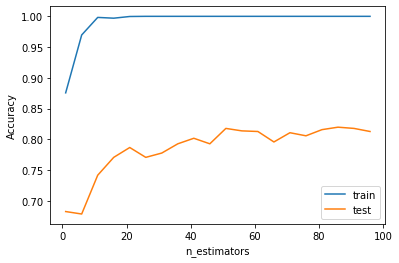

In [182]:
plt.plot(n_estimators_dict['n_estimators'], n_estimators_dict['train_score'], label = 'train')
plt.plot(n_estimators_dict['n_estimators'], n_estimators_dict['test_score'], label = 'test')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For the `n_estimators` hyperparameter, the training accuracy reaches to 1.0 for n_estimators > 31. The test accuracy more or less starts plateauing at this point. After 31, some models could be overfitting as their test_scores decrease.

Now I want to see how deep should each tree go. I'll try with trees from 1 stump to 40 levels. 

In [183]:
max_depth_dict = {'depth':[], 'train_score':[], 'test_score':[]}

for depth in range(1, 40, 2):
    random_forest = RandomForestClassifier(n_estimators = 20, max_depth = depth)
    random_forest.fit(X_train, y_train)
    
    train_score = random_forest.score(X_train, y_train)        
    test_score = random_forest.score(X_test, y_test)    

    max_depth_dict['depth'].append(depth)        
    max_depth_dict['train_score'].append(train_score)
    max_depth_dict['test_score'].append(test_score)    
    
max_depth_df = pd.DataFrame(max_depth_dict)
max_depth_df

,depth,train_score,test_score
0,1,0.58525,0.569
1,3,0.74050,0.714
2,5,0.80100,0.747
3,7,0.84000,0.754
4,9,0.87175,0.775
5,11,0.88950,0.779
6,13,0.90050,0.778
7,15,0.92375,0.788
8,17,0.94025,0.797
9,19,0.95000,0.781


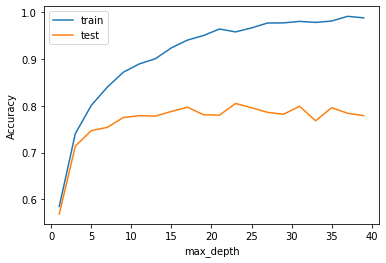

In [184]:
plt.plot(max_depth_dict['depth'], max_depth_dict['train_score'], label = 'train')
plt.plot(max_depth_dict['depth'], max_depth_dict['test_score'], label = 'test')
plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

For the `max_depth` hyperparameter, the training accuracy keeps increasing but the test accuracy plateaus after max_depth = 11 indicating overfitting. 

**Some advantages of random forests include**
1. Powerful and a great classifier. 
2. Predictions are faster than $k$-NN 

**Disdvantages of random forests**
1. Slow training.

However, how much randomness is there really in **random** forests? Do the results change drastically if we re-fit a forest using the same data and same hyperparameters? Should that be that worrying?

In [185]:
train_accuracies = []
test_accuracies = []

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(X_imdb, y_imdb, test_size = 0.20)
    random_forest = RandomForestClassifier(n_estimators=5, max_depth = 100)
    random_forest.fit(X_train, y_train)
    train_accuracies.append(random_forest.score(X_train, y_train))    
    test_accuracies.append(random_forest.score(X_test, y_test))

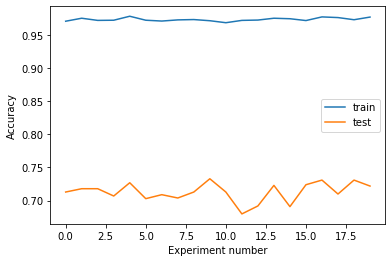

In [186]:
plt.plot(range(20), train_accuracies, label = 'train')
plt.plot(range(20), test_accuracies, label = 'test')
plt.xlabel('Experiment number')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Exploring symbols as features

During the preprocessing of the data, I realized that some symbols were being considered as important features. This made me curious to figure out why some symbols would be considered such important features. 

I will see which features are being crucial despite being symbols.

In [200]:
pd.set_option('display.max_rows', 100)
importance_equal = importances.sort_values(by='Gini-importance', ascending=False)
#importance_equal[101:200]

In [201]:
# 'n't' is an important feature
importance_equal.loc['n\'t']

Gini-importance    23.779692
Name: n't, dtype: float64

We can see that n't is in the top 100 of most important features. We can see what reviews that use n't say and see if most movie reviews with this feature are positive or negative.

In [203]:
sub = 'n\'t'
odd_char_df = imdb_df_subset
odd_char_df["odd_char"]= odd_char_df["review"].str.find(sub) > 0 
odd_char_df.head(10)

,Unnamed: 0,type,review,label,file,odd_char
24639,24639,test,"When I first saw this show, I was 9, and it ca...",pos,9677_10.txt,False
30822,30822,train,I'm not sure why Spike Lee made this train wre...,neg,3991_4.txt,False
4404,4404,test,Do you get it? Like the car. These are the jok...,neg,2714_2.txt,False
4004,4004,test,"As I post this comment, IMDb currently rates A...",neg,2354_3.txt,True
43136,43136,train,I saw this film in the worst possible circumst...,pos,3823_9.txt,True
15294,15294,test,I'm amazed that Memento (which is an excellent...,pos,1265_10.txt,True
48200,48200,train,This movie i've loved since i was young! Its e...,pos,8381_8.txt,True
30739,30739,train,We all know a movie never does complete justic...,neg,3916_3.txt,True
25407,25407,train,"This movie was poorly written, poorly acted an...",neg,10367_4.txt,True
19981,19981,test,I just saw this movie for the first time last ...,pos,5484_10.txt,False


In [211]:
pd.set_option('display.max_colwidth', -1)
odd_char_df[['review', 'odd_char', 'label']][odd_char_df['odd_char'] == True].head()

,review,odd_char,label
4004,"As I post this comment, IMDb currently rates Alfred Hitchcock's subpar Saboteur a 7.3/10. Personally, I rated it less than half that. Honestly, I can't tell how a movie this bad could've come from what is probably the most consistently good director I know of. I've seen about 10 other Hitch movies from the 30's-60's. Vertigo is thus far my hands down favorite while Saboteur is easily the worst. It's hard to believe that 7 years earlier Hitch used the very same formula in The 39 Steps far more competently. My recommendation would be to see that instead and avoid this like the plague. It's the only Hitchcock movie that I turned off before before the end and have no desire to go back and see the rest. If you must watch it, then rent or borrow. Don't make the mistake I did and buy the DVD on good faith earned through Notorious, Rebecca, Vertigo, Rear Window, etc. Even a master screws up sometimes, I guess.<br /><br />EDIT: Maybe I was a bit harder on this film than I should've been. It's certainly nowhere near Ed Wood or Manos or anything like that, but there's three reasons I feel I must rate it so low:<br /><br />1) The name ""Hitchcock"" brings with it certain expectations of quality. This film delivers on a few of them, but they're way overshadowed by the darn near non-sensical plotting.<br /><br />2) I want to compensate a bit for all the 8+ ratings this film is getting. Hitchcock is like the John Coltrane of directors. True fans will find reasons to consider anything by him a work of art, but the high rating on IMDb gives more casual movie enthusiasts like myself the impression that this movie is far better than it actually is. <br /><br />3) I spent $18 on this. Maybe if it'd cost me $5 or even $10 I'd probably be a bit less bitter. ;)",True,neg
43136,"I saw this film in the worst possible circumstance. I'd already missed 15 minutes when I woke up to it on an international flight between Sydney and Seoul. I didn't know what I was watching, I thought maybe it was a movie of the week, but quickly became riveted by the performance of the lead actress playing a young woman who's child had been kidnapped. The premise started taking twist and turns I didn't see coming and by the end credits I was scrambling through the the in-flight guide to figure out what I had just watched. Turns out I was belatedly discovering Do-yeon Jeon who'd won Best Actress at Cannes for the role. I don't know if Secret Sunshine is typical of Korean cinema but I'm off to the DVD store to discover more.",True,pos
15294,"I'm amazed that Memento (which is an excellent flick) is so well-regarded in the Top 250 and this one doesn't even appear!! What the hell is that?? To be honest - when this movie ended my knee-jerk reaction was that this movie is better than Memento. After the euphoria of the fabulous ending wore off, I concluded that they are equal in their excellence. I am just confused about why its not in the Top 50 along with Memento. I'm going to venture a guess that (sadly) it's because it's in black and white or because (again sadly)that the characters all have British accents ...sadly because that is no reason to not appreciate a great movie like this.<br /><br />I'm telling you that if you loved Memento, you will love Following as well. Brilliant!",True,pos
48200,"This movie i've loved since i was young! Its excellent. Although, it may be a bit much for the average movie watcher if one can't interpret certain subtleties in the film (for example, our hero's name is Achilles, and in the final battle between him and Alexander he's shot in the heel with a rocket, just as Achilles in mythology was shot in his heel). That's a just a little fact that is kind of amusing! Anyway, great movie, good story, it'd be neat to see it redone with today's special effects! Oddly enough, Gary Graham had average success, starring in the T.V. show Alien Nation. This movie is a fun watch and should be more appreciated!",True,pos
30739,"We a

In [213]:
label_count_df = odd_char_df[['review', 'odd_char', 'label']][odd_char_df['odd_char'] == True]
label_count_df.label.value_counts()

neg    1702
pos    1286
Name: label, dtype: int64

This clearly shows a game of how negatives can mean that a movie review is negative. However, 43% of the viewers used a negative to describe that they were surprised the film is not considered a great movie. 
For example, this review:

`I saw this film in the worst possible circumstance  I didn't know what I was watching, \[...\] Turns out I was belatedly discovering Do-yeon Jeon who'd won Best Actress at Cannes for the role. `

Some other symbols, with a lower GINI can also play important roles. and might be more intuitive after reading the reviews and see why they could actually be important. Let's take a look at `*****`

In [193]:
# Found '*****' to be an important feature
importance_equal.loc['*****']

Gini-importance    0.403272
Name: *****, dtype: float64

In [118]:
#feature_names

In [225]:
star = '*****'

In [226]:
# Data frame to see *****
df_stars = imdb_df_subset
df_stars["odd_char"]= imdb_df_subset["review"].str.find(star) > 0 
#df_stars.head()

In [227]:
count_stars = df_stars[['review', 'odd_char', 'label']].sort_values(by = 'odd_char', ascending = False)

In [228]:
count_stars[count_stars['odd_char'] == True].head(5)

,review,odd_char,label
47303,"This is one of the best of the series, ranking up there with Resident Evil 3: Nemesis (Or Biohazard: Last Escape) The game has a very good storyline in which you play as Claire Redfield in the search for her brother,Chris Redfield (Whom you probably know from the original Resident Evil) It is as scary as the other Resident Evil, and contains alot more cutscenes.<br /><br />My Rating: **** out of ***** Stars (Rating based on comparison to other videogames)",True,pos
45266,"The emotional powers and characters of Dominick and Eugene are the things that Hollywood doesn't make anymore. This is one of the most emotional, sensitive, and heart-felt movies that I have ever seen! Roy Liotta, Tom Hulce, and supporting actress Jamie Lee Curtis, deliver Oscar Winning caliber performances! There are not enough words to express how great this movie is. Sure, people who are not into sentimental movies may not care as much as the rest of us about Dominick and Eugene, but for the rest of us, this movie goes right to the heart and sole of compassion and humanity. You will never forget this film, EVER!<br /><br />*****SPOILERS BELOW*****<br /><br />The simple yet eloquent story is masterfully told. Eugene is a med-school intern who faces long hours and a demanding work load at the hospital. His fraternal twin brother Dominick (born 12 minutes earlier) is a little slow and awkward because of brain damage due to a victim of abuse by their father. (A heartbreaking moment when this is found out in the film that will leave you in tears!) Eugene (a.k.a ""Geno"") faces a painful dilemma. He must decide whether to finish medical school, which would mean accepting his residency in another city and leave Dominick (a.k.a ""Nicky"") behind, or forfeit the rest of his education to take care of him. Nicky helps pay his brother's med-school tuition by working as a trash collector.<br /><br />The questions of ethics, morals, and responsibilities are masterfully blended in this landmark movie. Just when Gino thinks Nicky might be making progress toward independence, Dominick turns around and winds up doing things like helping out a drug dealer, or tying to use a faulty cord that he finds at the dump on an electrical appliance.<br /><br />Larry, is ""The Character"" and Nicky's partner on his garbage route who fills gullible Dominick's head with all kinds of stories like Geno and Jennifer (his girlfriend, whom he is tutoring in Clinical Pharmacology) going to Atlantic City and gambling away all their money. But deep down, you can see that Larry cares for him. On their rounds, Nicky also befriends a little boy, whom we find out has also been beaten by his father. An end result is also tragic and the pain that you see on Nicky's face when it happens, speaks volumes.<br /><br />The sensitivity that the two brothers share for each other can not be overstated enough. All Nicky wants to do is be loved and look for acceptance in anyway he can. (i.e he goes to church, loves Hulk Hogan) Geno loves Nicky more than anything in the world. But can his brother become independent enough so that Geno can pursue his dream of becoming a doctor? A brilliant film that should have gotten tons more recognition than it deserved, but unfortunately came out around the same time as Rain Man, which dealt with a similar issue. However, I like Dominick and Eugene better because it has a far stronger emotional component. Be forewarned that this movie is aimed right at the tear-ducts, so have Kleenex handy! What a film!!!!",True,pos
17534,"Trey's favourite from the first run of Season 10 and also one of my personal favourites, Manbearpig features the adventure of Al Gore before going on global warming and before the movie, it was similar a adventure certainly, Al Gore was also trying to aware the world about something that can change the Earth, something really dangerous, this time about something that is half man half bear and half pig, Al Gore had only one thing 

In [229]:
count_stars.label.value_counts()

neg    2529
pos    2471
Name: label, dtype: int64

Here we can see that `*****` has two main meanings: say that something is worth 5 stars or censor a viewer's bad comments. 